# Finding Label Errors in MNIST Image Dataset with CNNs

This example demonstrates the use of a cleanlab-compatible PyTorch ConvNet classifier to find label issues in the MNIST dataset.

Code is adapted from v1 examples (see `contrib/v1` folder)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch, torchvision
from cleanlab.experimental.mnist_pytorch import CNN, MNIST_TEST_SIZE, MNIST_TRAIN_SIZE
import cleanlab
import numpy as np
from PIL import Image

import sys
import os
import traceback
from datetime import datetime as dt
import copy

from sklearn.metrics import confusion_matrix, accuracy_score

# Important! Make fonts Type I fonts (necessary for publishing in ICML and other conference)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from torchvision import datasets

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download MNIST and set-up train/test/labels

X_train = np.arange(MNIST_TRAIN_SIZE)
X_test = np.arange(MNIST_TEST_SIZE)
# X_train = X_train[X_train % 10 == 0]
y_train = datasets.MNIST("../data", train=True, download=True).train_labels.numpy()
y_test = datasets.MNIST("../data", train=False, download=True).test_labels.numpy()
py_train = cleanlab.internal.util.value_counts(y_train) / float(len(y_train))
X_train_data = datasets.MNIST("../data", train=True).train_data.numpy()


## Finding label errors in MNIST training set


In [3]:
def imshow(
    inp,
    img_labels=None,
    img_pred=None,
    img_fns=None,
    figsize=(10, 10),
    normalize=False,
    method_name="",
    savefig=False,
):
    """Imshow for Tensor."""
    height, width = inp.shape[1:]
    xbins = 8
    ybins = int(np.ceil(len(img_labels) / xbins))
    xbin_width = width // xbins
    ybin_height = height // ybins

    inp = inp.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    ax = plt.figure(figsize=figsize).gca()
    ax.imshow(inp)
    pad_size = (8 - len(img_pred) % 8) % 8
    img_labels = img_labels + [""] * pad_size  # padding
    img_pred = img_pred + [""] * pad_size  # padding
    img_fns = img_fns + [""] * pad_size  # padding
    #     grid = np.asarray(img_labels).reshape((ybins, xbins))

    num_red_boxes = 0
    for (j, i), idx in np.ndenumerate(np.arange(ybins * xbins).reshape((ybins, xbins))):
        prediction = img_pred[idx]
        label = img_labels[idx]
        img_fn = img_fns[idx]
        image_index = int(img_fn[13:])

        plt.hlines(
            [j * ybin_height - 0.5],
            xmin=i * xbin_width,
            xmax=i * xbin_width + xbin_width,
            color="lightgray",
            linewidth=2,
        )

        fontsize = (
            max(min(1.4 * figsize[0], 0.9 * figsize[0] - 0.7 * len(prediction)), 12)
            if prediction != ""
            else 1
        )
        tt = ax.text(
            i * xbin_width + xbin_width / 2,
            j * ybin_height + ybin_height / 20,
            prediction,
            ha="center",
            va="center",
            fontsize=fontsize,
        )
        tt.set_bbox(dict(facecolor="lime", alpha=0.8, edgecolor=None))

        fontsize = (
            min(0.5 * figsize[0], 1.25 * figsize[0] - len(img_fn))
            if img_fn != ""
            else 1
        )
        tt = ax.text(
            i * xbin_width + xbin_width / 2.8,
            j * ybin_height + ybin_height / 7,
            img_fn,
            ha="center",
            va="center",
            fontsize=fontsize,
        )
        tt.set_bbox(dict(facecolor="lightgray", alpha=0.8, edgecolor=None))

        fontsize = (
            max(min(1.4 * figsize[0], 0.9 * figsize[0] - 0.7 * len(label)), 12)
            if label != ""
            else 1
        )
        t = ax.text(
            i * xbin_width + xbin_width / 2,
            j * ybin_height + ybin_height / 10 * 9,
            label,
            ha="center",
            va="center",
            fontsize=fontsize,
        )
        t.set_bbox(dict(facecolor="cyan", alpha=0.8, edgecolor=None))

        if image_index in [
            21601,
            40466,
            29922,
            40144,
            51248,
            43454,
            59915,
            57662,
            25678,
            2676,
            24798,
            31727,
            7080,
            26560,
            10994,
            53396,
            54264,
        ]:  # , 59701, 42566, 26940, 47759
            # Draw red bounding box
            plt.hlines(
                [j * ybin_height + 0.5, (j + 1) * ybin_height - 1.5],
                xmin=i * xbin_width - 0.3,
                xmax=i * xbin_width + xbin_width - 0.65,
                color="red",
                linewidth=15,
            )
            plt.vlines(
                [i * xbin_width + 0.5, (i + 1) * xbin_width - 1.5],
                ymin=j * ybin_height + 0.5,
                ymax=j * ybin_height + ybin_height - 0.5,
                color="red",
                linewidth=15,
            )
            num_red_boxes += 1

    # print("Number of red boxes:", num_red_boxes)
    plt.axis("off")
    if savefig:
        plt.savefig(
            "figs/mnist_training_label_errors"
            + str(len(img_pred))
            + "_"
            + method_name
            + ".pdf",
            pad_inches=0.0,
            bbox_inches="tight",
        )
    plt.pause(0.001)  # pause a bit so that plots are updated


We train the CNN model and then obtain the out-of-sample predicted probabilies using cross validation.

In [4]:
%%time
# Constants
savefig = False
max_images = 24
seed = 43

# Pre-train
np.random.seed(43)
cnn = CNN(epochs=50, log_interval=100, loader='train') #pre-train

# Out-of-sample cross-validated holdout predicted probabilities
np.random.seed(4)

# Run cross-validation
cj, pred_probs = cleanlab.count.estimate_confident_joint_and_cv_pred_proba(X_train, y_train, clf=cnn, )
est_py, est_nm, est_inv = cleanlab.count.estimate_latent(cj, y_train)

TrainEpoch: 1 [0/48000 (0%)]	Loss: 2.318980
TrainEpoch: 1 [6400/48000 (13%)]	Loss: 2.085061
TrainEpoch: 1 [12800/48000 (27%)]	Loss: 1.180747
TrainEpoch: 1 [19200/48000 (40%)]	Loss: 0.771938
TrainEpoch: 1 [25600/48000 (53%)]	Loss: 0.811048
TrainEpoch: 1 [32000/48000 (67%)]	Loss: 0.579529
TrainEpoch: 1 [38400/48000 (80%)]	Loss: 0.720406
TrainEpoch: 1 [44800/48000 (93%)]	Loss: 0.405209
TrainEpoch: 2 [0/48000 (0%)]	Loss: 0.583078
TrainEpoch: 2 [6400/48000 (13%)]	Loss: 0.642222
TrainEpoch: 2 [12800/48000 (27%)]	Loss: 0.287425
TrainEpoch: 2 [19200/48000 (40%)]	Loss: 0.426255
TrainEpoch: 2 [25600/48000 (53%)]	Loss: 0.275920
TrainEpoch: 2 [32000/48000 (67%)]	Loss: 0.305533
TrainEpoch: 2 [38400/48000 (80%)]	Loss: 0.320276
TrainEpoch: 2 [44800/48000 (93%)]	Loss: 0.527106
TrainEpoch: 3 [0/48000 (0%)]	Loss: 0.450063
TrainEpoch: 3 [6400/48000 (13%)]	Loss: 0.225127
TrainEpoch: 3 [12800/48000 (27%)]	Loss: 0.325741
TrainEpoch: 3 [19200/48000 (40%)]	Loss: 0.517511
TrainEpoch: 3 [25600/48000 (53%)]	Loss

These are the different cleanlab methods for selecting noise, for more details view [`cleanlab/filter.py`](https://docs.cleanlab.ai/stable/cleanlab/filter.html).

In [5]:
methods = [
    "prune_by_class",
    "prune_by_noise_rate",
    "both",
]  

Here we can see the identified label errors found using the different cleanlab methods:

Method: prune_by_class
Number of estimated errors in training set: 115


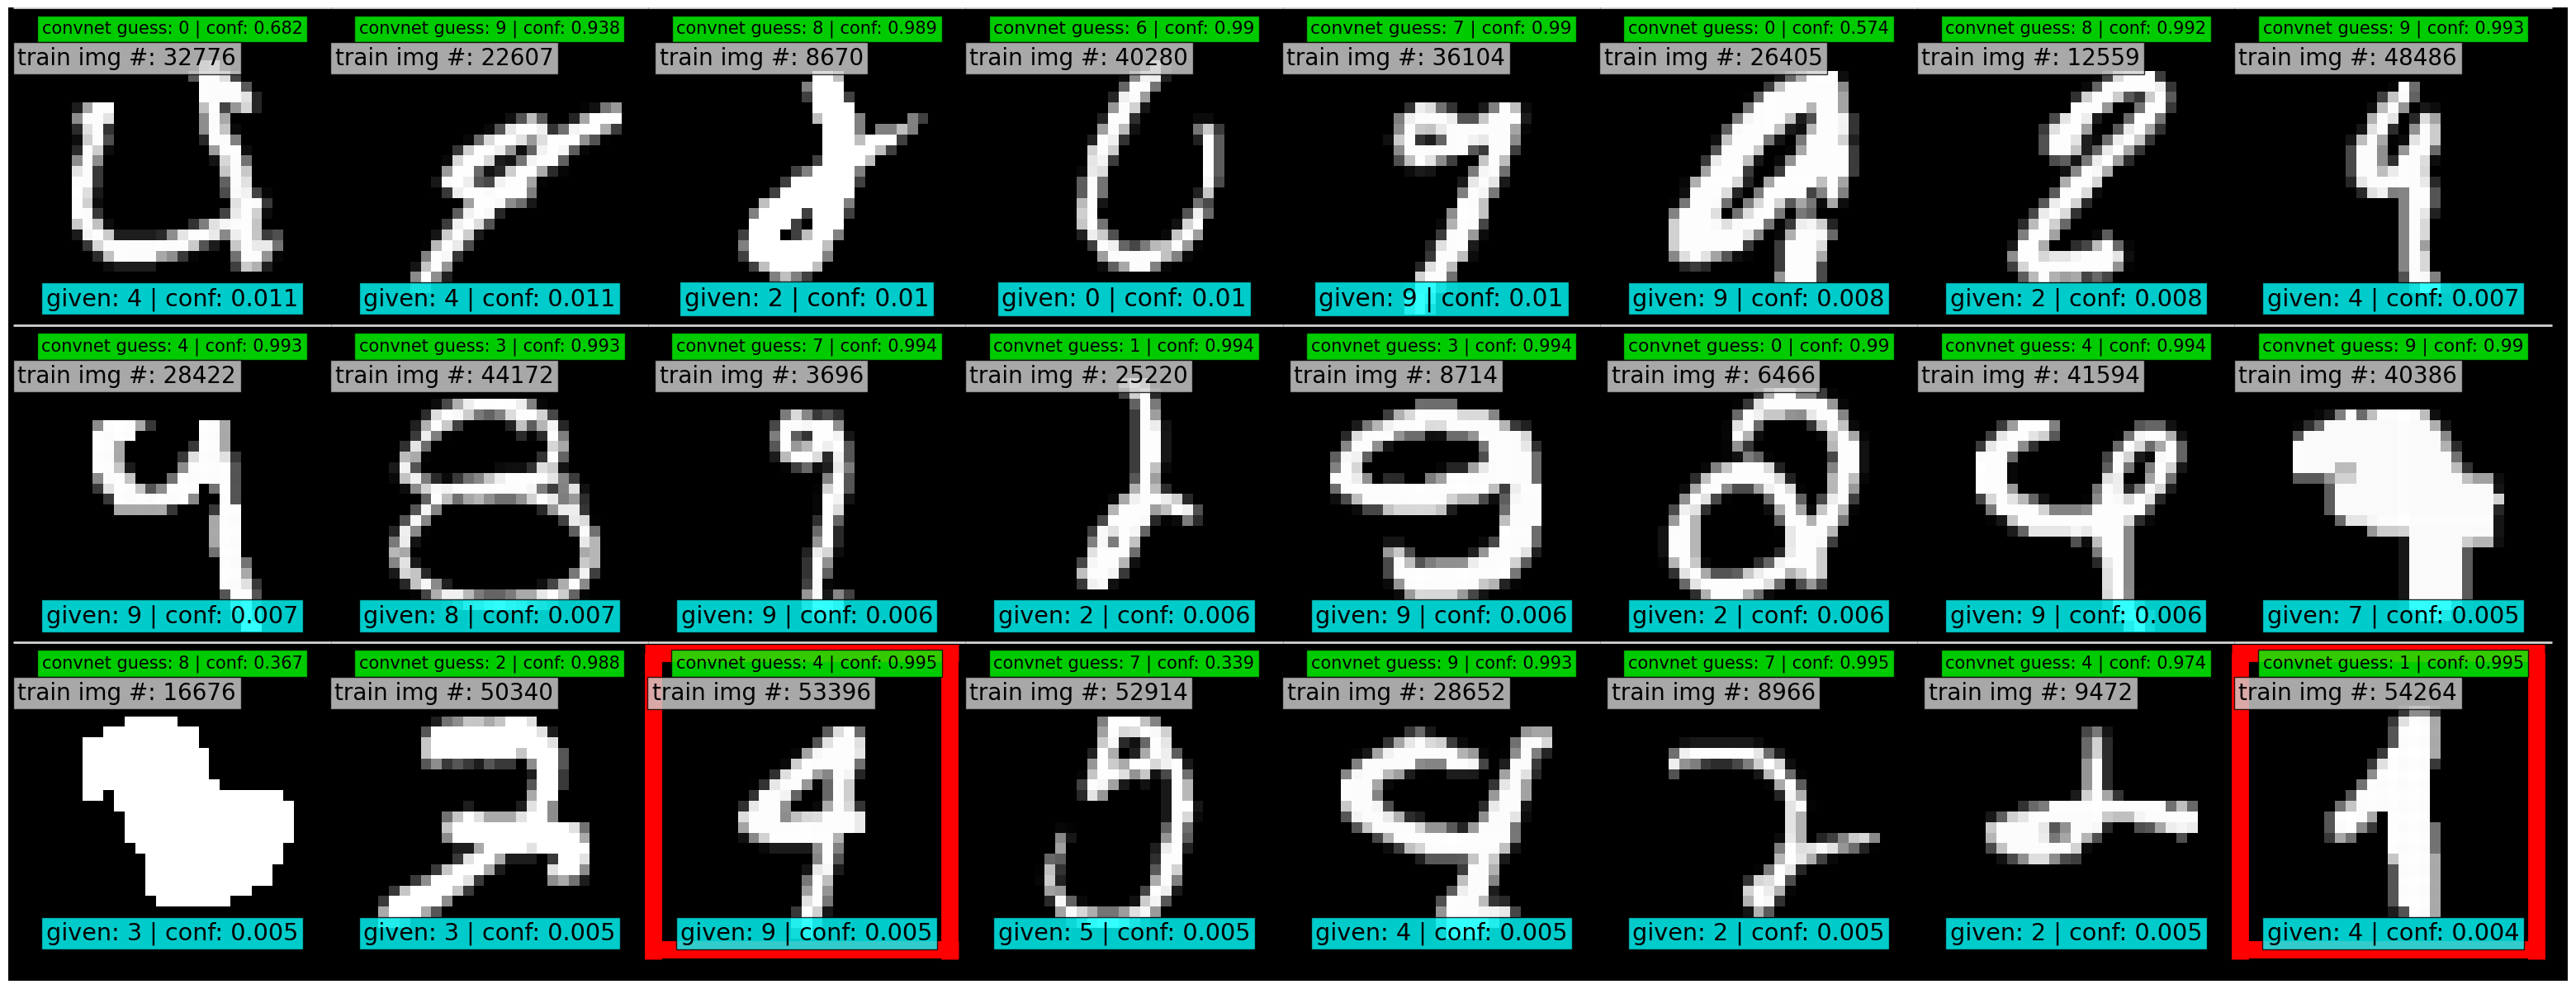

Method: prune_by_noise_rate
Number of estimated errors in training set: 115


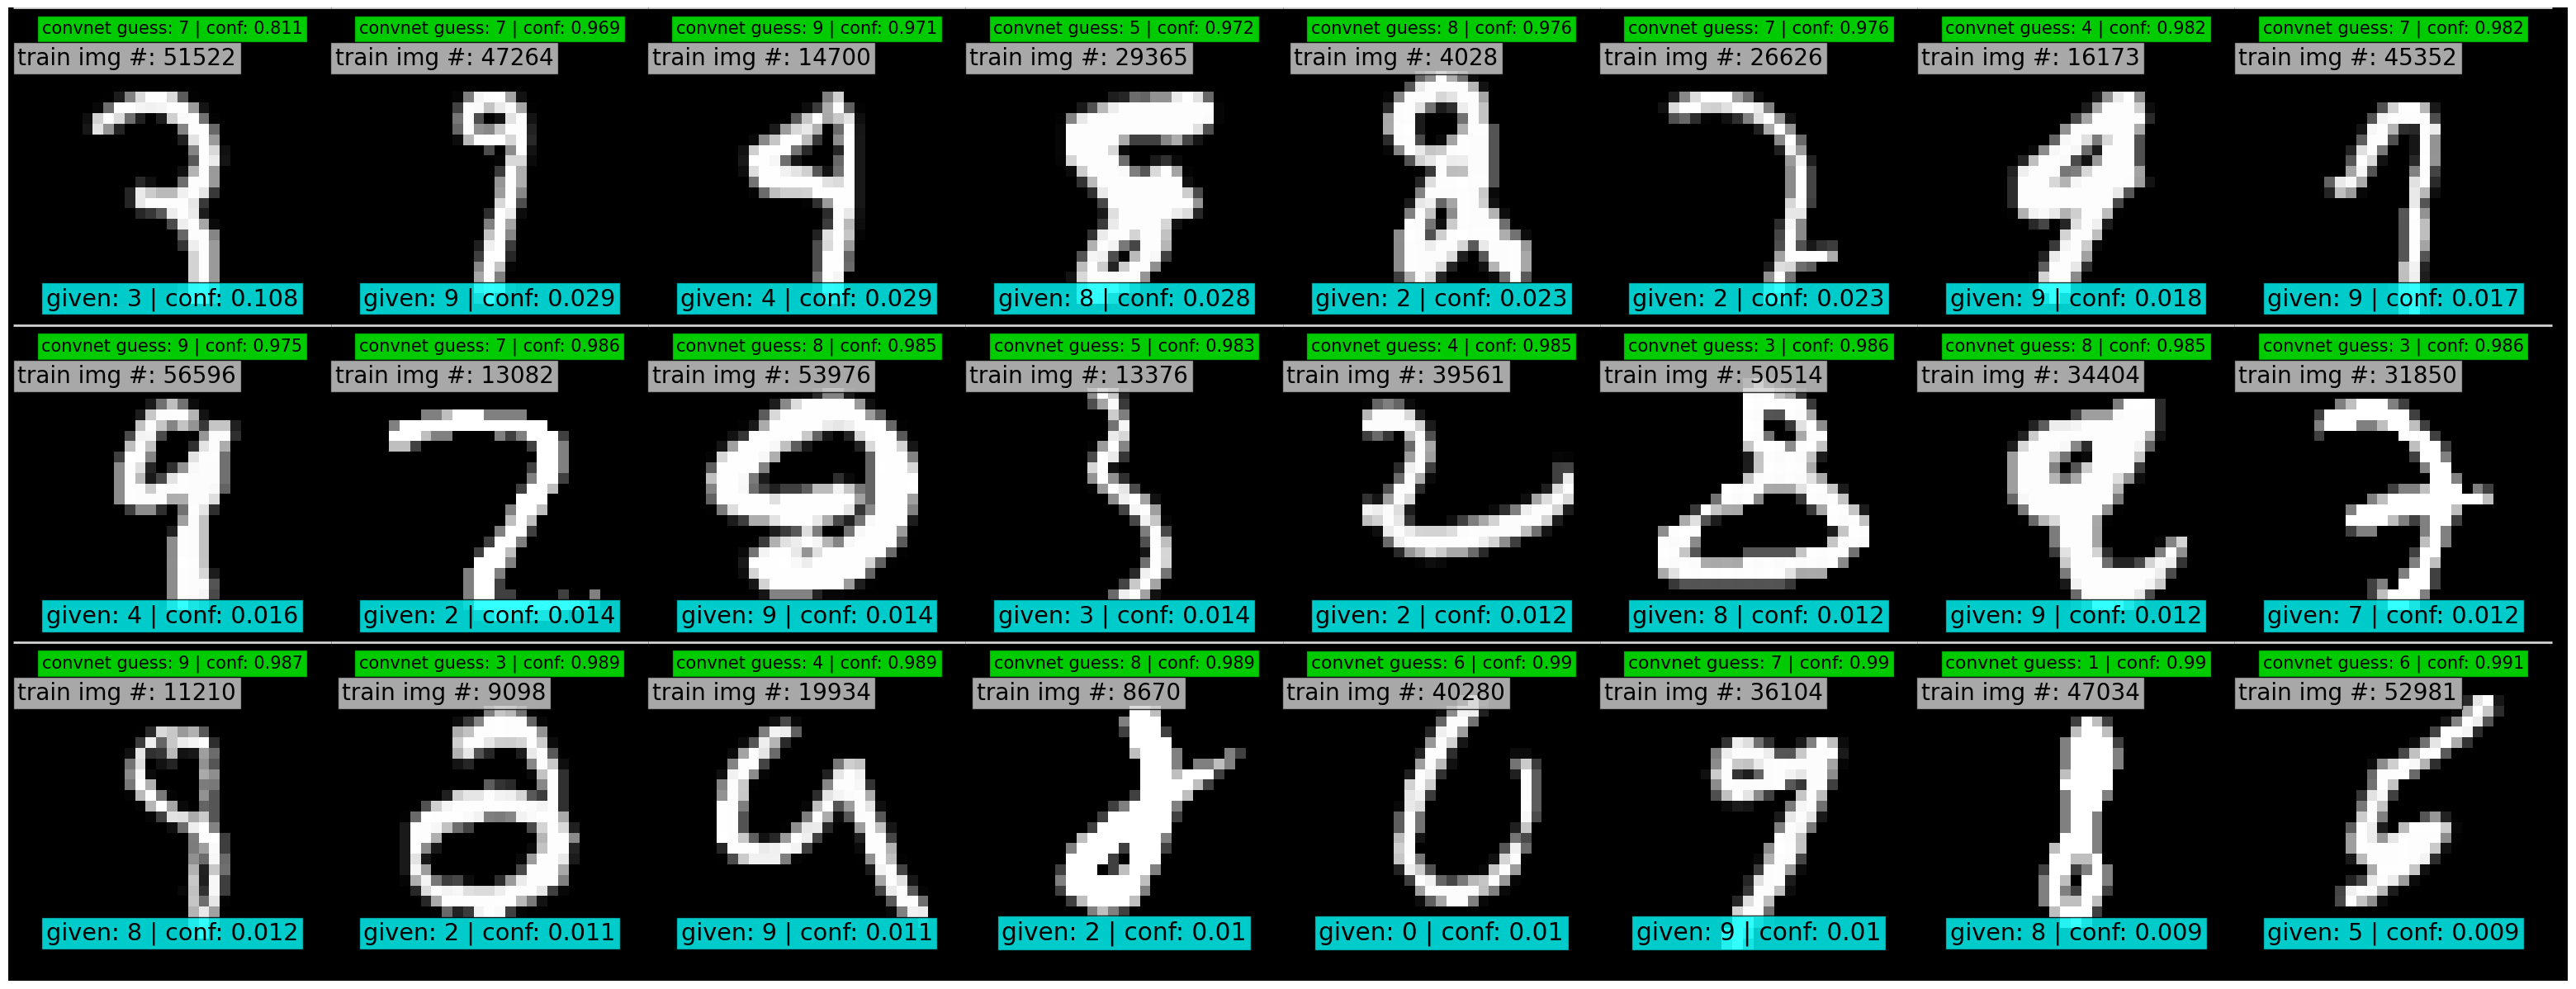

Method: both
Number of estimated errors in training set: 90


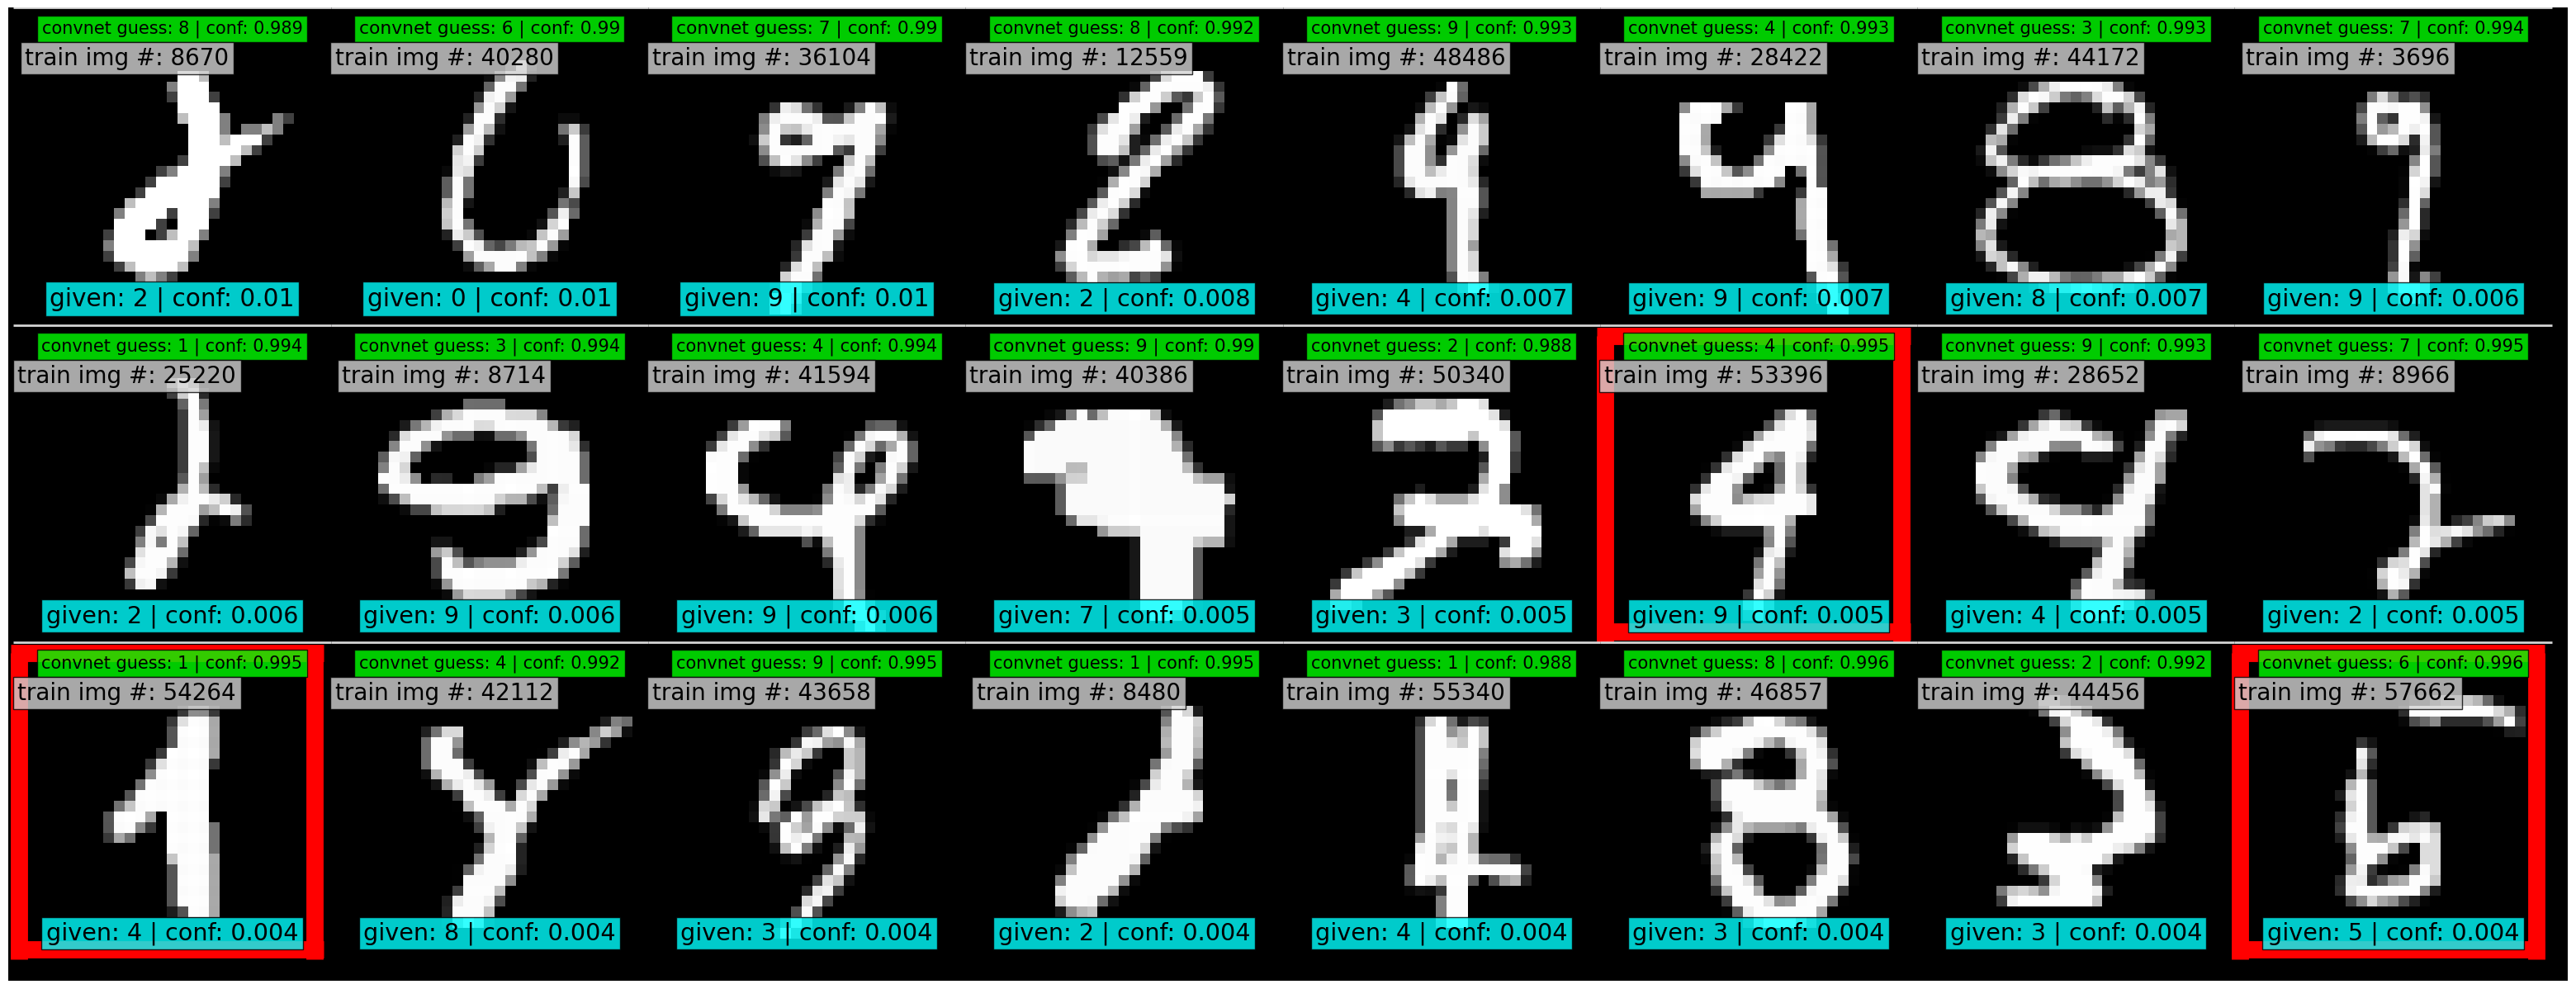

In [6]:
for method in methods:
    print("Method:", method)
    noise_idx = cleanlab.filter.find_label_issues(
        y_train, pred_probs, filter_by=method, confident_joint=cj
    )
    print("Number of estimated errors in training set:", sum(noise_idx))
    pred = np.argmax(pred_probs, axis=1)

    # Prepare and display figure ordered by lowest predicted probability
    if sum(noise_idx) >= max_images:
        ordered_noise_idx = np.argsort(
            np.asarray([pred_probs[i][j] for i, j in enumerate(y_train)])[noise_idx]
        )[::-1]
        #     ordered_noise_idx = np.argsort(np.asarray([pred_probs[idx,y_train[idx]] - pred_probs[idx,pred[idx]] for idx in range(len(y_train)) ])[noise_idx]) # order by difference in predicted prob and given label prob

        prob_given = np.asarray([pred_probs[i][j] for i, j in enumerate(y_train)])[noise_idx][
            ordered_noise_idx
        ][:max_images]
        prob_pred = np.asarray([pred_probs[i][j] for i, j in enumerate(pred)])[noise_idx][
            ordered_noise_idx
        ][:max_images]
        img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
        label4viz = y_train[noise_idx][ordered_noise_idx][:max_images]
        pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

        graphic = torchvision.utils.make_grid(
            torch.from_numpy(
                np.concatenate([X_train_data[img_idx][:, None]] * 3, axis=1)
            )
        )
        img_labels = [
            "given: "
            + str(label4viz[w])
            + " | conf: "
            + str(np.round(prob_given[w], 3))
            for w in range(len(label4viz))
        ]
        img_pred = [
            "convnet guess: "
            + str(pred4viz[w])
            + " | conf: "
            + str(np.round(prob_pred[w], 3))
            for w in range(len(pred4viz))
        ]
        img_fns = ["train img #: " + str(item) for item in img_idx]

        # Display image
        imshow(
            graphic,
            img_labels=img_labels,
            img_pred=img_pred,
            img_fns=img_fns,
            figsize=(40, max_images / 1.1),
            method_name=method,
            savefig=savefig,
        )
        plt.show()
    else:
        print("max_images is too large. Not enough images to display.")
